## Exporting pixel-wise fluorescence parameter to reconstruct MFIS-FRET 2D histograms

In this script, we use the previously defined pixel classes of vesicle-like structure,
cytoplasm and nucleus of the mGBP example data set. Based on these pixel classes, we export
for each pixel mean donor fluorescence lifetime and fluorescence intensities (per color and
timewindow (prompt - delay).
Additionally, derived parameter, e.g. apparent FRET efficiency or effective Stoichiometry, are
exported. 
To select for the pixel of interest, we use the generated binary masks of cytosol, VLS and nucleus.
In these masks, all pixel outside the area of interest are 0, and all pixel inside the region of 
interest are 1. Thus, by multiplying the fluorescence images with the masks, the pixel inside the
region of interest are selected. 
For comparison, we also export the same data from the non-segmented image. Here, we include all pixel 
with more then 20 photons in our analysis.

Finally, we reshape the image from 256x256 pixel into a single column vector (65'536 x 1), where the 
rows are stacked beneath each other. These reshaped arrays are exported as raw text files and can
be visualized as one- or twodimensional histograms e.g. using the matplotlib built-in functions or
any calculation program.

Please note, for simplicity reasons, we stacked here all frames and use averaged masks for
pixel selection.

In [20]:
# Import all required libraries
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, img_as_ubyte
from skimage.filters import threshold_otsu
from matplotlib.ticker import IndexLocator

## Load the previously exported data

In [21]:
# Donor mean fluorescence lifetime - based on stacked frames
mean_tau_green_img = "./FLIM/mGBP_DA.ht3_mean tau green.tif"
mean_tau_green = io.imread(mean_tau_green_img)

# Intensity images - split by color channel and timewindow (prompt & delay)
green_intensity_img = "./FLIM/mGBP_DA.ht3_green_SUM.tif"
green_intensity = io.imread(green_intensity_img)

red_prompt_intensity_img = "./FLIM/mGBP_DA.ht3_red_prompt_SUM.tif"
red_prompt_intensity = io.imread(red_prompt_intensity_img)

red_delay_intensity_img = "./FLIM/mGBP_DA.ht3_red_delay_SUM.tif"
red_delay_intensity = io.imread(red_delay_intensity_img)

## Generating a pseudo-mask for the whole image
(Only pixels with at least 20 photons in total should be included in the analysis)

In [22]:
minimum_nr_photons = 20
lines, pixel = mean_tau_green.shape  # Determine the image size
# Calculate intensity sum
sum_intensity = green_intensity + red_prompt_intensity + red_delay_intensity
# Set all pixel to 0 where the intensity sum is <= 20, 
# all pixel above 20 are set to 1
min_mask = np.where(sum_intensity >= minimum_nr_photons, 1, 0)

## Load the previously defined masks for cytoplasm, vesicles and nucleus

In [52]:
# Note that for cytoplasm and vesicles a mask was generated per image frame, here we use for simplicity an average mask.

cytoplasm_file = "./FLIM/mGBP_DA.ht3_sum.tif_wo nucleus_vesicles.tif"
cytoplasm_mask = img_as_ubyte(io.imread(cytoplasm_file))

cytoplasm_avg = np.array(np.sum(cytoplasm_mask, axis=0), dtype=int)
thresh_cyto = threshold_otsu(cytoplasm_mask) # Apply Otsu thresholding
cytoplasm_avg_mask = cytoplasm_avg > thresh_cyto

VLS_file = "./FLIM/mGBP_DA.ht3_sum.tif_binary_vesicles.tif"
VLS_mask = img_as_ubyte(io.imread(vesicles_file))

VLS_avg = np.array(np.sum(VLS_mask, axis=0), dtype=int)
thresh_VLS = threshold_otsu(VLS_avg) # Apply Otsu thresholding
VLS_avg_mask = VLS_avg > thresh_VLS

nucleus_avg_file = "./FLIM/mGBP_DA.ht3_sum.tif_avg_nucleus.tif"
nucleus_avg_mask = img_as_ubyte(io.imread(nucleus_avg_file))

## Calculation of the derived parameter

In [53]:
# effective Stoichiometry-PIE 
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# Note: effective Spie as we omit all correction factors

Spie = (nA_FRET + nD) / (nA_FRET + nD + nA_direct)

# Proximity ratio
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# for correct FRET efficiency, a correction factor is required: gamma
# gamma defines the ratio of the detector sensitivities
# E = nA(FRET) /(nA(FRET) + gamma * nD)

PR = nA_FRET / (nA_FRET + nD)

/tmp/ipykernel_2620977/581684700.py:5: RuntimeWarning: invalid value encountered in divide
  Spie = (nA_FRET + nD) / (nA_FRET + nD + nA_direct)
/tmp/ipykernel_2620977/581684700.py:13: RuntimeWarning: invalid value encountered in divide
  PR = nA_FRET / (nA_FRET + nD)


## Generating a list of pixel coordinates

In [43]:
pixel_id = np.indices((lines, pixel))
pixel_id_1D = pixel_id.reshape((2, lines*pixel))
Y_pixel = np.array(pixel_id_1D[0, :])
X_pixel = pixel_id_1D[1, :]

## Select the pixel of interest

In [58]:
# here, each parameter is multiplied with the generated & selected mask

#mask = min_mask
#mask = cytoplasm_avg_mask
#mask = VLS_avg_mask
mask = nucleus_avg_mask

tau_green = mean_tau_green * mask
nD = green_intensity * mask
nA_FRET = red_prompt_intensity * mask
nA_direct = red_delay_intensity * mask

## Reshaping the parameter matrices

In [59]:
# all parameter are reshaped from 256 x 256 array -> 65'536 array
tau_green_1D = tau_green.reshape((lines * pixel))
nD_1D = nD.reshape((lines * pixel))
nA_FRET_1D = nA_FRET.reshape((lines * pixel))
nA_direct_1D = nA_direct.reshape((lines * pixel))
Spie_1D = Spie.reshape((lines * pixel))
PR_1D = PR.reshape((lines * pixel))

## Plot the 2D histograms

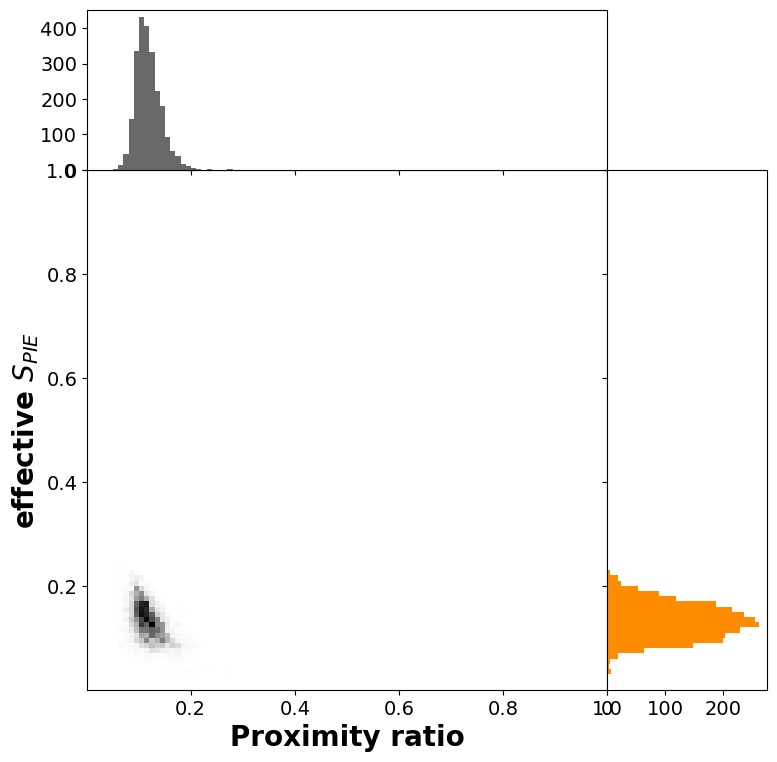

In [71]:
x = PR_1D
y = Spie_1D

xlabel = "Proximity ratio"
ylabel = "effective $S_{PIE}$"

bins_x = 100
bins_y = 100
bins = (bins_x, bins_y)
range_x = (1e-3, 1)  # Setting the minimum slightly above Zero excludes 
range_y = (1e-3, 1)  ## the zeros which are in the masked pixels

# 3. Define a grid
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height, width, 0.2]
rect_histy = [left + width, bottom, 0.2, height]

# 4. Define 2D histogram for SPIE vs EFRET
def scatter_hist(x, y, ax, ax_histx, ax_histy):
    # labels of the marginal distribution
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)
    # the 2D histogram:
    hist2D = ax.hist2d(x, y, bins=bins, range=((range_x), (range_y)), density=True, cmap='Greys')
    # marginal distributions
    xhist = ax_histx.hist(x, bins=bins_x, range=range_x, color="dimgrey")
    yhist = ax_histy.hist(y, bins=bins_y, range=range_y, color="darkorange", orientation='horizontal')

    return hist2D, xhist, yhist

fig = plt.figure(figsize=(8, 8))

ax = fig.add_axes(rect_scatter)
ax.set_xlabel(xlabel, fontsize=20,  fontweight='bold')
ax.set_ylabel(ylabel, fontsize=20,  fontweight='bold')
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)
for label in (ax.get_xticklabels() + ax.get_yticklabels() + ax_histx.get_yticklabels() + ax_histy.get_xticklabels()):
	label.set_fontsize(14)
#ax_histx.yaxis.set_major_locator(IndexLocator(base=1000, offset=500))
#ax_histy.xaxis.set_major_locator(IndexLocator(base=2000, offset=1000))

# use the previously defined function
xy2D, x_1D, y_1D = scatter_hist(x, y, ax, ax_histx, ax_histy)
plt.show()

## Save the results

In [63]:
# This files can be read by any text editor
header = "Y pixel\tX pixel\tMean Tau(green) \tNumber of photons(green) \tNumber of photons(red prompt) \tNumber of photons(red delay) \teff Stoichiometry(PIE) \tProximity ratio"

# Saving directory
output_filename = './FLIM/mGBP_DA_nucleus.txt'

np.savetxt(
    output_filename,
    np.vstack([Y_pixel, X_pixel, tau_green_1D, nD_1D, nA_FRET_1D, nA_direct_1D, Spie_1D, PR_1D]).T,
    delimiter='\t',
    header=header
    )
